In [158]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# 我们先进行特征工程
## 该数据已经是经过标准化之后的了
data = pd.read_csv("diabetes.csv")
data.info()

# 怀孕：怀孕的次数

# 葡萄糖：口服葡萄糖耐量试验中血浆葡萄糖浓度超过2小时

# 血压：舒张压（mm Hg）

# SkinThickness：肱三头肌皮肤皱褶厚度（mm）

# 胰岛素：2小时血清胰岛素（μU/ ml）

# BMI：体重指数（体重kg /（身高m）2）

# DiabetesPedigreeFunction：糖尿病谱系功能（根据家族史评估糖尿病可能性的功能）

# 年龄：年龄（岁）

# 结果：类别变量（非糖尿病患者为0，糖尿病患者为1）

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [159]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


                          Pregnancies   Glucose  ...       Age   Outcome
Pregnancies                  1.000000  0.129459  ...  0.544341  0.221898
Glucose                      0.129459  1.000000  ...  0.263514  0.466581
BloodPressure                0.141282  0.152590  ...  0.239528  0.065068
SkinThickness               -0.081672  0.057328  ... -0.113970  0.074752
Insulin                     -0.073535  0.331357  ... -0.042163  0.130548
BMI                          0.017683  0.221071  ...  0.036242  0.292695
DiabetesPedigreeFunction    -0.033523  0.137337  ...  0.033561  0.173844
Age                          0.544341  0.263514  ...  1.000000  0.238356
Outcome                      0.221898  0.466581  ...  0.238356  1.000000

[9 rows x 9 columns]


<AxesSubplot:>

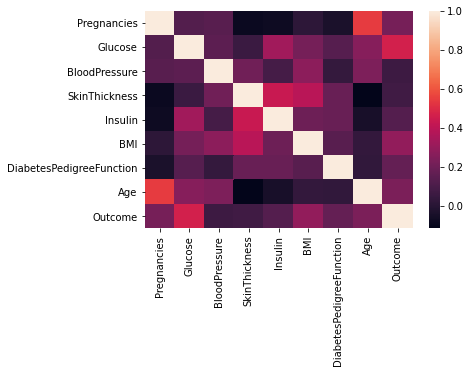

In [160]:
## 计算person系数之前不需要标准化，person系数只能表示线性相关关系，还需要兼具spearman系数观察单调相关关系
corr = data.corr(method='pearson')
print(corr)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns)

                          Pregnancies   Glucose  ...       Age   Outcome
Pregnancies                  1.000000  0.130734  ...  0.607216  0.198689
Glucose                      0.130734  1.000000  ...  0.285045  0.475776
BloodPressure                0.185127  0.235191  ...  0.350895  0.142921
SkinThickness               -0.085222  0.060022  ... -0.066795  0.089728
Insulin                     -0.126723  0.213206  ... -0.114213  0.066472
BMI                          0.000132  0.231141  ...  0.131186  0.309707
DiabetesPedigreeFunction    -0.043242  0.091293  ...  0.042909  0.175353
Age                          0.607216  0.285045  ...  1.000000  0.309040
Outcome                      0.198689  0.475776  ...  0.309040  1.000000

[9 rows x 9 columns]


<AxesSubplot:>

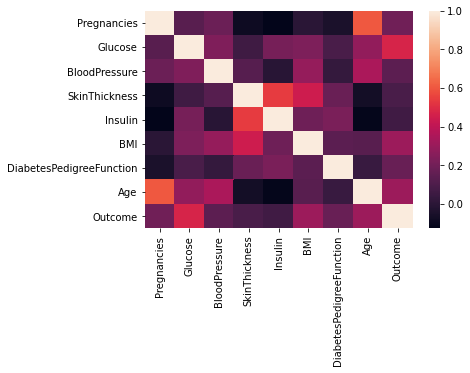

In [161]:
# https://support.minitab.com/zh-cn/minitab/18/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/
## spearman系数和person系数 ！！！
corr_spear = data.corr(method='spearman')
print(corr_spear)
sns.heatmap(corr_spear, 
         xticklabels=corr_spear.columns, 
         yticklabels=corr_spear.columns)


In [162]:
## 我们先不选择特征试试
### 我们先标准化处理（z-score归一化）

from sklearn.preprocessing import StandardScaler
 
#标准化，返回值为标准化后的数据｜
data_new = StandardScaler().fit_transform(data.values[:,:-1])

In [164]:
X = data_new
y = data.values[:, [-1]]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.25)     #8:2比较好
Xtest = torch.from_numpy(Xtest)
Ytest = torch.from_numpy(Ytest)
Xtest = Xtest.to(torch.float32)
Ytest = Ytest.to(torch.float32)
# print(Xtest.dtype)
class DiabetesDataset(Dataset):
    def __init__(self, data,label):
 
        self.len = data.shape[0] # shape(多少行，多少列)
        self.x_data = torch.from_numpy(data)
        self.x_data = self.x_data.to(torch.float32)
        self.y_data = torch.from_numpy(label)
        self.y_data = self.y_data.to(torch.float32)
 
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
 
    def __len__(self):
        return self.len
 
 
train_dataset = DiabetesDataset(Xtrain,Ytrain)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=0) #num_workers 多线程
 
# design model using class
 
 
class Model(torch.nn.Module): 
    def __init__(self):
        super(Model, self).__init__() 
        self.linear1 = torch.nn.Linear(8, 6) 
        self.linear2 = torch.nn.Linear(6, 4) 
        self.linear3 = torch.nn.Linear(4, 1) 
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.linear1(x)) 
        x = self.sigmoid(self.linear2(x)) 
        x = self.sigmoid(self.linear3(x)) 
        return x

model = Model()
criterion = torch.nn.BCELoss(size_average=True)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
 
 
# training cycle forward, backward, update
 
def train(epoch):
    train_loss = 0.0
    count = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        #print(inputs)
        y_pred = model.forward(inputs)
 
        loss = criterion(y_pred, labels)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        count = i
 
    if epoch%2000 == 1999:
        print("train loss:", train_loss/count,end=',')
 
 
def test():
    with torch.no_grad():
        y_pred = model(Xtest)
        y_pred_label = torch.where(y_pred>=0.5,torch.tensor([1.0]),torch.tensor([0.0]))
        #print(y_pred)
        acc = torch.eq(y_pred_label, Ytest).sum().item() / Ytest.size(0)
        print("test acc:", acc)
 
if __name__ == '__main__':
    for epoch in range(1000):
        train(epoch)
        if epoch%100==1:
            test()
    

tensor([[0.3643],
        [0.3652],
        [0.3652],
        [0.3635],
        [0.3636],
        [0.3618],
        [0.3637],
        [0.3638],
        [0.3636],
        [0.3647],
        [0.3645],
        [0.3648],
        [0.3632],
        [0.3654],
        [0.3630],
        [0.3627],
        [0.3642],
        [0.3657],
        [0.3648],
        [0.3631],
        [0.3652],
        [0.3650],
        [0.3653],
        [0.3651],
        [0.3638],
        [0.3638],
        [0.3634],
        [0.3652],
        [0.3650],
        [0.3643],
        [0.3646],
        [0.3660],
        [0.3653],
        [0.3639],
        [0.3645],
        [0.3646],
        [0.3647],
        [0.3641],
        [0.3619],
        [0.3656],
        [0.3634],
        [0.3636],
        [0.3630],
        [0.3642],
        [0.3654],
        [0.3646],
        [0.3641],
        [0.3630],
        [0.3658],
        [0.3637],
        [0.3640],
        [0.3630],
        [0.3629],
        [0.3653],
        [0.3670],
        [0